In [45]:
import numpy as np
import os 
import cv2
import random
import gc
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import decomposition

### 数据集导入与处理

In [46]:
def load_data(path):
    imgs = []
    labels = []
    os.chdir(path)
    for dir in os.listdir():
        # print(root.split("Person"))
        label = int(dir.split("Person")[1])
        for file in os.listdir(dir):
            img = cv2.imread(os.path.join(os.getcwd(), dir, file), cv2.IMREAD_GRAYSCALE).flatten() # 读取数据并转换为1维长向量
            imgs.append(img)
            labels.append(label)
    print(len(imgs))
    print(len(labels))
    return imgs, labels

def split_train_test(data, labels, rate):
    assert len(data) == len(labels)
    total_num = len(data)
    train_num = int(rate * len(data))
    test_num = len(data) - train_num
    train_data = []
    train_labels = []
    test_labels = []
    test_data = []
    
    test_selected = []
    train_selected = []
    num = 0
    while num < test_num:
        idx = random.randint(0, total_num-1)
        if not idx in test_selected:
            test_selected.append(idx)
            num +=1
            
    train_selected = list(set(list(range(total_num))).difference(set(test_selected)))
    
    for idx in test_selected:
        test_data.append(data[idx])
        test_labels.append(labels[idx])
    
    for idx in train_selected:
        train_data.append(data[idx])
        train_labels.append(labels[idx])
        
    return np.array(train_data).T, np.array(train_labels), np.array(test_data).T, np.array(test_labels)

def split_data_in_labels(data, labels):
    assert len(data) == len(labels)
    classes = len(labels) / 10
    test_data = []
    train_data = []
    test_labels = []
    train_labels = []
    test_selected = []
    train_selected = []
    for i in range(int(classes)):
        test_selected.append(i*10 + random.randint(0, 9))
        test_selected.append(i*10 + random.randint(0, 9))

    train_selected = list(set(list(range(len(data)))).difference(set(test_selected)))
    
    for idx in test_selected:
        test_data.append(data[idx])
        test_labels.append(labels[idx])
    
    for idx in train_selected:
        train_data.append(data[idx])
        train_labels.append(labels[idx])
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)



data, labels = load_data("/home/li/repository/cvlab/data")
# train_data, train_labels, test_data, test_labels = split_train_test(data, labels, 0.8)
train_data, train_labels, test_data, test_labels = split_data_in_labels(data, labels)

del data, labels
gc.collect()
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)


410
410
(333, 5600) (82, 5600) (333,) (82,)


In [47]:
class PCA():
    def __init__(self, k):
        self.k = k
    
    def fit(self, X):
        """PCA数据降维

        Args:
            X (np.array (n_samples, n_features)): _description_

        Returns:
            feat_space (n_samples, k)： 降维后的训练数据
        """
        n_samples, n_features = X.shape
        assert n_features >= self.k
        self.train_num = X.shape[1]
        self.X_mean = np.mean(X, axis=0)
        X_std = (X-self.X_mean)
        
        # faster
        cov = np.cov(X.T, rowvar=False)
        # u1:(n_samples, n_samples)
        w1, u1 = np.linalg.eig(cov)
        # u1: (n_samples, n_samples)
        u1 = np.dot(X_std.T, u1)
        # project_matrix:(n_features, k)
        project_matrix = np.real(u1[:, np.argsort(w1)[::-1][:self.k]])
        # feat_space:(n_samples, k)
        feat_space = np.dot(X_std, project_matrix)
        self.project_matrix = project_matrix
        return feat_space

    def transform(self, X, project_matrix=None):
        """对数据进行降维

        Args:
            X (n_samples, n_features): 数据
            project_matrix (n_features, k): 投影矩阵
        """
        if project_matrix is None:
            return np.dot((X-self.X_mean), self.project_matrix)
        else:
            return np.dot((X.T-self.X_mean), project_matrix)

    

In [48]:
class KPCA():
    def __init__(self, k, sigma):
        self.k = k
        self.sigma = sigma
    
    @staticmethod
    def kernel_filter_gaussian(X, sigma):
        """计算K矩阵
        Args:
            X (np.array (n_samples, n_features)): _description_
            sigma: 高斯核参数
            
        Returns:
            K (n_samples, n_samples)
        """
        K = np.zeros((X.shape[0], X.shape[0]))
        for i in range(K.shape[0]):
            for j in range(K.shape[1]):
                K[i, j] = np.exp(-np.linalg.norm(X[i, :]-X[j, :])**2 / (2*sigma**2))                
        return K
    
    @staticmethod
    def kernel_filter_gausian_xi(X, xi, sigma):
        k = np.zeros(X.shape[0])
        for i in range(k.shape[0]):
            k[i] = np.exp(-np.linalg.norm(X[i, :]-xi)**2 / (2*sigma**2))   
        
        return k

    def kernel_filter_multinominal(self, X, a, c, d):
        """𝑘(𝑥,𝑦)=(𝑎𝑥^𝑇𝑦+𝑐)^𝑑

        Args:
            X (_type_): _description_
            a (_type_): _description_
            c (_type_): _description_
            d (_type_): _description_

        Returns:
            _type_: _description_
        """
        K = np.zeros((X.shape[1], X.shape[1]))
        for i in range(K.shape[0]):
            # for j in range(K.shape[1]):
            #     K[i, j] = np.dot(X[:, i], X[:, j]) + c 
            K[i] = self.multinominal_kernel(X, X[:, i], a, c, d)            
        return K
    @staticmethod
    def multinominal_kernel(X, xi, a, c, d):
        k = np.zeros(X.shape[1])
        for i in range(k.shape[0]):
            k[i] = (np.dot(X[:, i], xi)*a + c)**d
        
        return k       
    
    def fit(self, X):
        """KPCA数据降维

        Args:
            X (np.array (n_samples, n_features)): _description_
            sigma: 高斯核参数

        Returns:
            feat_space (n_samples, k)： 降维后的训练数据
        """
        n_samples, n_features = X.shape
        assert n_features >= self.k
        self.train_num = X.shape[0]
        self.X_mean = np.mean(X, axis=0)
        X_std = (X - self.X_mean)
        self.X = X_std
        # K_matrix = self.kernel_filter_multinominal(X, 1/40, 0, 2)
        # K_matrix: (n_samples. n_samples)
        K_matrix = self.kernel_filter_gaussian(X_std, self.sigma)
        # faster
        # u1:(sample_num, sample_num)
        # print("K_matrix:", K_matrix)
        w1, u1 = np.linalg.eig(K_matrix)
        # project_matrix:(n_samples, k)
        project_matrix = np.real(u1[:, np.argsort(w1)[::-1][:self.k]])
        self.project_matrix = project_matrix
        # print(w1, u1)
        # feat_space:(n_samples, k)
        feat_space = np.dot(K_matrix, project_matrix)
        return feat_space

    def transform(self, X, project_matrix=None):
        """利用训练好的KPCA对数据进行降维

        Args:
            X ((n_test_samples, n_features)): _description_
            project_matrix (project_matrix (n_samples, k), optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        K = np.zeros([X.shape[0], self.k])
        X = (X-self.X_mean)
        for i in range(X.shape[0]):
            K[i, :] = np.dot(self.kernel_filter_gausian_xi(self.X, X[i, :], self.sigma), self.project_matrix)
        return K



In [49]:
import scipy
class LDA():
    def __init__(self, n_components=5):
        self.n_components = n_components
    
    def fit(self, train_data, train_labels, solver="eigen"):
        """使用线性判别分析对train_data进行降维，
        维度为self.n_components

        Args:
            train_data (np.array(n_samples, features)): _description_
            train_labels (n_samples): _description_
        """
        if solver == "eigen":
            self.project_matrix = self._solver_eigen(train_data, train_labels)
        return self.transform(train_data)

    def _solver_eigen(self, train_data, train_labels):
        """使用特征值求解的方式进行LDA

        Args:
            train_data (_type_): _description_
            train_labels (_type_): _description_

        Returns:
            _type_: _description_
        """
        n_samples = train_data.shape[0]
        n_features = train_data.shape[1]
        labels_unique = np.unique(train_labels)
        # 首先计算各个类的均值
        # 然后计算类内散度矩阵Sw
        # 两个循环合并
        means = []
        Swi = []
        for label in labels_unique:
            Xg = train_data[train_labels==label, :]          # 取出相同标签的数据
            means.append(np.mean(Xg, axis=0))
            Swi.append(np.cov(Xg, rowvar=False))        # cov默认为列向量，这里设置rowvar从而以行向量为单个样本
        train_data_mean = np.average(means, axis=0)
        Sw = np.average(Swi, axis=0)
        # 计算类间散度矩阵
        # 可以通过总体散度矩阵St-Sw得到Sb
        St = np.cov(train_data, rowvar=False)
        Sb = St - Sw
        # 计算特征值和特征向量
        evals, evecs = np.linalg.eig(np.dot(np.linalg.inv(Sw), Sb))
        # eig输出并不严格有序，需要根据特征值对特征向量进行排序
        evecs = evecs[:, np.argsort(evals)[::-1]]
        project_matrix = np.real(evecs[:, :self.n_components])
        return project_matrix

    def transform(self, test_data):
        """使用训练好的LDA对test_data进行降维

        Args:
            test_data (np.array(n_samples, features)): _description_
        Return:
            X_new (np.array(n_samples, n_components))
        """
        return np.dot(test_data, self.project_matrix)



### 测试比较三种不同数据降维方法的分类效果


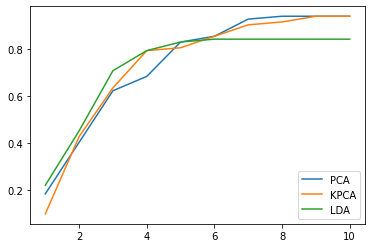

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# 统一分类器
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)

acc1 = []
acc2 = []
acc3 = []
k = list(range(1, 11))
# 使用PCA对训练数据进行降维，用于LDA
pca_tmp = PCA(40) 
train_data_new = pca_tmp.fit(train_data)
test_data_new = pca_tmp.transform(test_data)
# clf.fit(train_data_new, train_labels)
# baseline = clf.score(test_data_new, test_labels)
# print(baseline)

for i in k:
    pca = PCA(i)
    train_feats = pca.fit(train_data)
    test_feats = pca.transform(test_data)
    clf.fit(train_feats, train_labels)
    acc1.append(clf.score(test_feats, test_labels))

    kpca = KPCA(i, 10000)    # magic_num for gausian_kernel_filter
    train_feats = kpca.fit(train_data)
    test_feats = kpca.transform(test_data)
    clf.fit(train_feats, train_labels)
    acc2.append(clf.score(test_feats, test_labels))

    lda = LDA(i)
    train_feats = pca.fit(train_data_new)
    test_feats = pca.transform(test_data_new)
    clf.fit(train_feats, train_labels)
    acc3.append(clf.score(test_feats, test_labels))

with open("/home/li/repository/cvlab/acc.txt", 'w') as f:
    f.write("PCA:\n")
    for i in range(len(acc1)):
        f.write("k=%d, acc=%.5f\n" % (k[i], acc1[i]))
    f.write("KPCA:\n")
    for i in range(len(acc2)):
        f.write("k=%d, acc=%.5f\n" % (k[i], acc2[i]))
    f.write("LDA:\n")
    for i in range(len(acc2)):
        f.write("k=%d, acc=%.5f\n" % (k[i], acc3[i]))


fig = plt.figure()
ax = plt.subplot()
ax.plot(k, acc1, label="PCA")
ax.plot(k, acc2, label="KPCA")
ax.plot(k, acc3, label="LDA")
# ax.plot(k, [baseline] * len(k), label="LDA baseline")
plt.legend(loc=4)
plt.show()
